# Imports and data

In [1]:
import pandas as pd
import seaborn as sns
import utils.base_utils as bu
import utils.window_utils as wu
import numpy as np

start_date = '1971-09-30'
end_date = '2025-06-30'
maturities = ['1'] + [str(i) for i in range(1, 121) if i % 12 == 0] # select only yearly maturities plus rf

kr_yields = bu.get_yields(type='kr', start=start_date, end=end_date, maturities=maturities)
kr_forward = bu.get_forward_rates(kr_yields)
kr_xr = bu.get_excess_returns(kr_yields).dropna()
fred_md = bu.get_fred_data('data/2026-01-MD.csv', start=start_date, end=end_date) # this is aligned to the last day of the previous month, so we get the same number of observations as the yields data

# Drop dates after kr_xr becomes nan
kr_yields = kr_yields.loc[kr_yields.index <= kr_xr.index[-1]]
kr_forward = kr_forward.loc[kr_forward.index <= kr_xr.index[-1]]
kr_xr = kr_xr.loc[kr_xr.index <= kr_xr.index[-1]]
fred_md = fred_md.loc[fred_md.index <= kr_xr.index[-1]]

# Backfill fred_md to avoid nans
fred_md = fred_md.bfill()

In [62]:
import sklearn
import skglm
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

class LassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = sklearn.linear_model.Lasso(alpha=self.alpha)
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
class LinearModel:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.model = sklearn.linear_model.LinearRegression()
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
class GroupLassoModel:
    def __init__(self, alpha=0.01):
        self.alpha = alpha

    def fit(self, X, y):
        self.model = skglm.GroupLasso(alpha=self.alpha, groups=[10, 20, 30, 76])
        self.model.fit(X, y)
    
    def predict(self, X):
        return self.model.predict(X)
    
class NNModel:
    def __init__(self, hidden_size=32, epochs=200, lr=0.001):
        self.hidden_size = hidden_size
        self.epochs = epochs
        self.lr = lr
        self.scaler = None
        self.model = None

    def fit(self, X, y):
        self.scaler = StandardScaler()
        X_s = X.astype(np.float32)
        y_t = torch.tensor(y.astype(np.float32)).reshape(-1, 1)
        X_t = torch.tensor(X_s)

        input_size = X_s.shape[1]
        self.model = nn.Sequential(
            nn.Linear(input_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, 1)
        )

        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()

        self.model.train()

        for _ in range(self.epochs):
            optimizer.zero_grad()
            pred = self.model(X_t)
            loss = loss_fn(pred, y_t)
            loss.backward()
            optimizer.step()

    def predict(self, X):
        # X_s = self.scaler.transform(X).astype(np.float32)
        X_t = torch.tensor(X.astype(np.float32))
        self.model.eval()
        with torch.no_grad():
            return self.model(X_t).numpy().flatten()

# Expanding window estimation

In [63]:
OOS_start = pd.Timestamp('1989-01-31')

X = fred_md.values
# add forward rates as additional features
X = np.hstack([X, kr_forward.values])
y = kr_xr['24'].values # 2-year excess returns
dates = kr_xr.index

X = kr_forward.values

# Models to test
models = {
    # 'Lasso': LassoModel(alpha=0.01),
    # 'Linear': LinearModel(),
    # 'GroupLasso': GroupLassoModel(alpha=0.01),
    'NN': NNModel(hidden_size=5, epochs=20, lr=0.001)
}

results = {}

for name, model in models.items():
    print(f"Running {name}...")
    y_forecast = wu.expanding_window(model, X, y, dates, OOS_start)
    r2 = wu.oos_r2(y, y_forecast)
    results[name] = {'forecast': y_forecast, 'R2_OOS': r2}
    print(f"  R2_OOS = {r2:.4f}")

# Summary
print("\n--- OOS R² Summary ---")
for name, res in results.items():
    print(f"  {name}: {res['R2_OOS']:.4f}")

Running NN...
  R2_OOS = -0.2290

--- OOS R² Summary ---
  NN: -0.2290


<Axes: xlabel='date'>

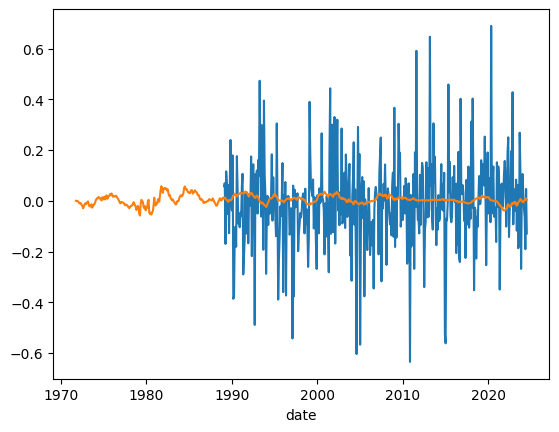

In [54]:
sns.lineplot(y=y_forecast, x=kr_yields.index)
sns.lineplot(y=y, x=kr_yields.index)